# Tahap 1

In [3]:
import os
import re
import glob
from datetime import datetime
from io import StringIO
from pdfminer.high_level import extract_text_to_fp
from pdfminer.layout import LAParams

SOURCE_DIR = 'C:/Users/super/OneDrive/Documents/VSCODE_Kuliah/src/Semester 6/PENALARAN/Case-Based-Reasoning/Case Based Reasoning/data/raw/CBR Case'
DEST_DIR = 'data/raw'
LOG_DEST = 'logs/cleaning.log'

def extract_text(pdf_path):
    output_string = StringIO()
    with open(pdf_path, 'rb') as fin:
        extract_text_to_fp(fin, output_string, laparams=LAParams(),
                           output_type='text', codec='utf-8')
    return output_string.getvalue()

def cleaning_text(input_text):
    if not input_text:
        return "", 0.0

    initial_length = len(input_text)
    
    teks = input_text.lower()
    teks = re.sub(r'disclaimer.*?email:.*?ext\.318\)', '', teks, flags=re.DOTALL)
    teks = re.sub(r'demikian diputuskan dalam rapat musyawarah.*', '', teks, flags=re.DOTALL)
    teks = re.sub(r'biaya peninjauan kembali:.*', '', teks, flags=re.DOTALL)

    # Proses per baris untuk membersihkan header, footer, dan watermark
    baris_bersih = []
    for baris in teks.splitlines():
        # Hapus header, URL, dan referensi putusan yang umum
        baris = re.sub(r'^\s*(direktori putusan|putusan\.mahkamahagung\.go\.id)', '', baris.strip())
        # Hapus nomor halaman dan footer terkait
        baris = re.sub(r'^(halaman \d+|put\. nomor.*)', '', baris)
        # Hapus watermark/kata-kata acak yang sering muncul sendiri dalam satu baris
        baris = re.sub(r'^\s*(kamah|agung|hkamah|nesia|onesi|indones|repubik)\s*$', '', baris)
        
        # Simpan hanya baris yang masih memiliki konten
        if baris.strip():
            baris_bersih.append(baris.strip())

    final_text = "\n".join(baris_bersih)
    final_text = re.sub(r'[ \t]{2,}', ' ', final_text)
    final_text = re.sub(r'\n\s*\n', '\n', final_text)
    
    # 4. Hitung rasio integritas yang akurat
    final_length = len(final_text)
    retention_ratio = final_length / initial_length if initial_length > 0 else 0

    return final_text, retention_ratio

def record_log(case_id, retention_ratio, status, detail=""):
    os.makedirs(os.path.dirname(LOG_DEST), exist_ok=True)
    with open(LOG_DEST, 'a', encoding='utf-8') as log:
        timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
        log.write(f"[{timestamp}] ID: {case_id} | Status: {status} | Integritas: {retention_ratio:.2%} {detail}\n")

def handling_pdf():
    print("Memulai proses batch...")
    os.makedirs(DEST_DIR, exist_ok=True)
    pdf_paths = sorted(glob.glob(os.path.join(SOURCE_DIR, '*.pdf')))
    
    if not pdf_paths:
        print("Tidak ada file PDF ditemukan di folder 'CBR Case'.")
        return

    for index, pdf_path in enumerate(pdf_paths, 1):
        case_id = f"case_{index:03d}"
        output_path = os.path.join(DEST_DIR, f"{case_id}.txt")
        file_name = os.path.basename(pdf_path)

        try:
            raw_text = extract_text(pdf_path)
            final_text, integrity_ratio = cleaning_text(raw_text)
            if integrity_ratio < 0.80:
                status = "GAGAL_VALIDASI"
                detail = f"HANYA {integrity_ratio:.2%} konten tersisa."
                print(f"⚠️ [PERINGATAN] {case_id} ({file_name}) | {detail}")
                record_log(case_id, integrity_ratio, status, detail)
            else:
                status = "SUKSES"
                detail = f"{integrity_ratio:.2%} konten valid."
                print(f"✅ [OK] {case_id} ({file_name}) | {detail}")
                with open(output_path, 'w', encoding='utf-8') as output:
                    output.write(final_text)
                
                record_log(case_id, integrity_ratio, status)

        except Exception as err:
            status = "ERROR_KRITIS"
            print(f"❌ [ERROR] Gagal memproses {file_name}: {str(err)}")
            record_log(case_id, 0, status, str(err))

    print("\nProses batch selesai.")
if __name__ == '__main__':
    handling_pdf()

Memulai proses batch...
✅ [OK] case_001 (putusan_1001_pdt.g_2024_pn_sby_20250620183217.pdf) | 97.46% konten valid.
✅ [OK] case_002 (putusan_1042_pk_pdt_2024_20250620181821.pdf) | 88.24% konten valid.
✅ [OK] case_003 (putusan_1042_pk_pdt_2024_20250620181935.pdf) | 88.24% konten valid.
✅ [OK] case_004 (putusan_1074_pdt.g_2024_pn_sby_20250620180900.pdf) | 96.28% konten valid.
⚠️ [PERINGATAN] case_005 (putusan_107_pdt.g_2024_pn_pal_20250620181515.pdf) | HANYA 71.63% konten tersisa.
✅ [OK] case_006 (putusan_1090_pdt.g_2024_pn_jkt.sel_20250620181108.pdf) | 97.52% konten valid.
✅ [OK] case_007 (putusan_1097_pdt.g_2024_pn_mdn_20250620181215.pdf) | 97.54% konten valid.
✅ [OK] case_008 (putusan_1099_pk_pdt_2022_20250620181947.pdf) | 92.07% konten valid.
✅ [OK] case_009 (putusan_1101_pdt.g_2024_pn_mdn_20250621013338.pdf) | 80.14% konten valid.
✅ [OK] case_010 (putusan_112_pdt.g_2025_pn_jkt.tim_20250620182858.pdf) | 95.79% konten valid.
✅ [OK] case_011 (putusan_121_pdt.g_2025_pn_mdn_20250620182527

# Tahap 2

In [4]:
import os
import re
import json
from collections import Counter

RAW_TEXT_DIR = 'data/raw'
PROCESSED_DIR = 'data/processed'

MAIN_CASES_PATH = os.path.join(PROCESSED_DIR, 'cases.json')
LENGTH_CASES_PATH = os.path.join(PROCESSED_DIR, 'length_cases.json')
BOW_CASES_PATH = os.path.join(PROCESSED_DIR, 'BoW_cases.json')
QA_CASES_PATH = os.path.join(PROCESSED_DIR, 'QA-Pairs_cases.json')

os.makedirs(PROCESSED_DIR, exist_ok=True)


# ==============================================================================
# BAGIAN 1: FUNGSI EKSTRAKSI METADATA
# ==============================================================================

def extract_metadata(full_text):
    no_perkara_match = re.search(r'nomor\s+([\w\./-]+)', full_text, re.IGNORECASE)
    no_perkara = no_perkara_match.group(1).strip() if no_perkara_match else ""

    tanggal_match = re.search(r'tanggal\s+(\d{1,2}\s+\w+\s+\d{4})', full_text, re.IGNORECASE)
    tanggal = tanggal_match.group(1).strip() if tanggal_match else ""

    pasal_patterns = [r'pasal\s+\d+\s*ayat\s*\(\d+\)', r'pasal\s+\d+', r'undang-undang\s+nomor\s+\d+\s+tahun\s+\d+']
    all_pasal_matches = []
    for pattern in pasal_patterns:
        matches = re.findall(pattern, full_text, re.IGNORECASE)
        all_pasal_matches.extend(matches)
    pasal = sorted(list(set(all_pasal_matches)))
    
    pihak = {"penggugat": [], "tergugat": []}
    antara_block = re.search(r'perkara antara:(.*?)lawan:', full_text, re.DOTALL | re.IGNORECASE)
    if antara_block:
        pihak["tergugat"] = [p.strip() for p in re.findall(r'\d+\.\s*(.*?)(?=,\s*berkedudukan|,s\s*bertempat)', antara_block.group(1))]
    
    lawan_block = re.search(r'lawan:(.*?)(mahkamah agung tersebut|dan\s*,?\s*turut termohon)', full_text, re.DOTALL | re.IGNORECASE)
    if lawan_block:
        pihak["penggugat"] = [p.strip() for p in re.findall(r'\d+\.\s*(.*?)(?=,\s*bertempat|,)', lawan_block.group(1))]
        
    fakta_match = re.search(r'((duduk perkara|menimbang,\s+bahwa\s+berdasarkan\s+surat-surat).*?)(?=mengadili:|amar putusan:)', full_text, re.DOTALL | re.IGNORECASE)
    ringkasan_fakta = ' '.join(fakta_match.group(1).split()) if fakta_match else ""

    amar_putusan = ""
    amar_match = re.search(r'^\s*(mengadili|amar putusan)\s*:?\s*(.*)', full_text, re.DOTALL | re.IGNORECASE | re.MULTILINE)
    
    if amar_match:
        amar_putusan = ' '.join(amar_match.group(2).split()).strip()
    
    if not amar_putusan:
        hukum_match = re.search(r'(menghukum.*)', full_text, re.DOTALL | re.IGNORECASE)
        if hukum_match:
            amar_putusan = ' '.join(hukum_match.group(1).split()).strip()

    if not amar_putusan:
        amar_putusan = ' '.join(full_text.split()[-300:])
        
    return {
        "no_perkara": no_perkara,
        "tanggal": tanggal,
        "ringkasan_fakta": ringkasan_fakta,
        "pasal": pasal,
        "pihak": pihak,
        "amar_putusan": amar_putusan
    }
# ==============================================================================
# BAGIAN 2: FUNGSI-FUNGSI FEATURE ENGINEERING
# ==============================================================================

STOP_WORDS = set(['dan', 'di', 'yang', 'untuk', 'pada', 'ke', 'itu', 'ini', 'adalah', 'dengan', 'bahwa', 'dari', 'telah', 'sebagai', 'para', 'dalam', 'atas', 'tersebut', 'oleh', 'namun', 'atau', 'maka', 'juncto', 'jo', 'jika'])

def calculate_word_count(text):
    return len(text.split())

def create_simple_bow(text):
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [word for word in words if word not in STOP_WORDS]
    return dict(Counter(filtered_words))

def create_qa_pairs(metadata):
    list_penuduh = metadata.get("pihak", {}).get("penggugat", [])
    penuduh_utama = list_penuduh[0] if list_penuduh else "Tidak ditemukan"

    list_tertuduh = metadata.get("pihak", {}).get("tergugat", [])
    tertuduh_utama = list_tertuduh[0] if list_tertuduh else "Tidak ditemukan"
    
    qa_pairs = {
        "Apa nomor perkaranya?": metadata.get("no_perkara", ""),
        "Pasal apa saja yang relevan?": ", ".join(metadata.get("pasal", [])),
        "Siapa pihak Penuduhnya?": penuduh_utama,    
        "Siapa pihak Tertuduhnya?": tertuduh_utama 
    }
    return qa_pairs

# ==============================================================================
# BAGIAN 3: PROSES UTAMA
# ==============================================================================

def represent_all_cases():
    print("🚀 Memulai Tahap 2: Representasi Kasus (Terminologi Diperbarui)...")
    
    all_cases_data, length_data, bow_data, qa_data = [], [], [], []
    file_list = sorted([f for f in os.listdir(RAW_TEXT_DIR) if f.endswith('.txt')])
    
    for filename in file_list:
        case_id_str = filename.replace('.txt', '')
        case_id_int = int(case_id_str.split('_')[1])
        filepath = os.path.join(RAW_TEXT_DIR, filename)
        print(f"  -> Memproses: {filename}")
        with open(filepath, 'r', encoding='utf-8') as f:
            full_text = f.read()
            
        extracted_data = extract_metadata(full_text)
        all_cases_data.append({"case_id": case_id_int, **extracted_data, "text_full": full_text})
        length_data.append({"case_id": case_id_int, "jumlah_kata": calculate_word_count(full_text)})
        bow_data.append({"case_id": case_id_int, "bag_of_words_simple": create_simple_bow(full_text)})
        qa_data.append({"case_id": case_id_int, "qa_pairs": create_qa_pairs(extracted_data)})

    print(f"\nMenyimpan data ke dalam 4 file JSON terpisah...")
    
    with open(MAIN_CASES_PATH, 'w', encoding='utf-8') as f: json.dump(all_cases_data, f, indent=4, ensure_ascii=False)
    print(f"✅ Data utama disimpan di: {MAIN_CASES_PATH}")
    
    with open(LENGTH_CASES_PATH, 'w', encoding='utf-8') as f: json.dump(length_data, f, indent=4, ensure_ascii=False)
    print(f"✅ Data jumlah kata disimpan di: {LENGTH_CASES_PATH}")
        
    with open(BOW_CASES_PATH, 'w', encoding='utf-8') as f: json.dump(bow_data, f, indent=4, ensure_ascii=False)
    print(f"✅ Data Bag-of-Words disimpan di: {BOW_CASES_PATH}")

    with open(QA_CASES_PATH, 'w', encoding='utf-8') as f: json.dump(qa_data, f, indent=4, ensure_ascii=False)
    print(f"✅ Data QA-Pairs disimpan di: {QA_CASES_PATH}")

    print("\n🎉 Proses selesai.")

if __name__ == '__main__':
    represent_all_cases()

🚀 Memulai Tahap 2: Representasi Kasus (Terminologi Diperbarui)...
  -> Memproses: case_001.txt
  -> Memproses: case_002.txt
  -> Memproses: case_003.txt
  -> Memproses: case_004.txt
  -> Memproses: case_006.txt
  -> Memproses: case_007.txt
  -> Memproses: case_008.txt
  -> Memproses: case_009.txt
  -> Memproses: case_010.txt
  -> Memproses: case_011.txt
  -> Memproses: case_012.txt
  -> Memproses: case_013.txt
  -> Memproses: case_014.txt
  -> Memproses: case_015.txt
  -> Memproses: case_016.txt
  -> Memproses: case_017.txt
  -> Memproses: case_018.txt
  -> Memproses: case_019.txt
  -> Memproses: case_020.txt
  -> Memproses: case_021.txt
  -> Memproses: case_022.txt
  -> Memproses: case_023.txt
  -> Memproses: case_024.txt
  -> Memproses: case_025.txt
  -> Memproses: case_026.txt
  -> Memproses: case_027.txt
  -> Memproses: case_028.txt
  -> Memproses: case_029.txt
  -> Memproses: case_031.txt
  -> Memproses: case_032.txt
  -> Memproses: case_033.txt
  -> Memproses: case_034.txt
  -> M

# Tahap 3

In [5]:
import os
import json
import pandas as pd
import numpy as np
import joblib
from scipy.sparse import save_npz, load_npz # Lebih efisien untuk matriks sparse

# Impor library yang relevan dari Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

print("--- [1/5] Menginstal dan Mengimpor Library ---")
# Tidak perlu instalasi jika sudah ada di environment Anda
print("✅ Library siap.")

# --- [2/5] Konfigurasi Path dan Direktori ---
print("\n--- [2/5] Mengatur Konfigurasi Path ---")
project_root = os.getcwd() 
MODEL_DIR = os.path.join(project_root, "data", "models")
EVAL_DIR = os.path.join(project_root, "data", "eval")
PROCESSED_DIR = os.path.join(project_root, "data", "processed")

JSON_PATH = os.path.join(PROCESSED_DIR, "cases.json")
# Menghapus path SVM dan menambahkan path untuk artefak TF-IDF Cosine
NB_MODEL_PATH = os.path.join(MODEL_DIR, "nb_pipeline.pkl")
TFIDF_COSINE_VECTORIZER_PATH = os.path.join(MODEL_DIR, "tfidf_cosine_vectorizer.pkl")
TFIDF_COSINE_MATRIX_PATH = os.path.join(MODEL_DIR, 'tfidf_cosine_matrix.npz')
QUERY_PATH = os.path.join(EVAL_DIR, "queries.json")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(EVAL_DIR, exist_ok=True)
print("✅ Path dikonfigurasi.")

# --- [3/5] Memuat dan Mempersiapkan Data ---
print(f"\n--- [3/5] Memuat dan Mempersiapkan Data dari '{JSON_PATH}' ---")
df = pd.read_json(JSON_PATH)
df['text_for_training'] = df['ringkasan_fakta'].fillna(df['text_full'])
df.dropna(subset=['text_for_training'], inplace=True)
print(f"✅ Berhasil memuat dan mempersiapkan {len(df)} kasus.")

# --- [4/5] Mempersiapkan Dua Pipeline Model ---

# +++ Pipeline A: TF-IDF + Multinomial Naive Bayes (Klasifikasi) +++
print("\n--- [4/5 A] Memproses Pipeline Naive Bayes ---")
# Data untuk Naive Bayes perlu di-split untuk training dan evaluasi
X_nb = df['text_for_training'].astype(str)
y_nb = df['case_id'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_nb, y_nb, test_size=0.2, random_state=42)
print(f"   -> Data di-split menjadi {len(X_train)} train dan {len(X_test)} test.")

nb_pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    MultinomialNB()
)
nb_pipeline.fit(X_train, y_train)
print("   -> Model Naive Bayes berhasil dilatih.")

# Evaluasi cepat untuk melihat performa
print("\n      --- Laporan Klasifikasi Naive Bayes pada Data Test ---")
predictions_nb = nb_pipeline.predict(X_test)
print(classification_report(y_test, predictions_nb, zero_division=0))

# Simpan pipeline Naive Bayes yang sudah dilatih
joblib.dump(nb_pipeline, NB_MODEL_PATH)
print(f"   -> Pipeline Naive Bayes disimpan di: {NB_MODEL_PATH}")

# +++ Pipeline B: TF-IDF + Cosine Similarity (Retrieval Murni) +++
# Menggantikan bagian SVM sebelumnya
print("\n--- [4/5 B] Mempersiapkan Artefak untuk TF-IDF + Cosine Similarity ---")
# Untuk retrieval, kita menggunakan seluruh data sebagai database
corpus_cosine = df['text_full'].fillna('').tolist()

# Latih vectorizer pada seluruh korpus
tfidf_vectorizer_cosine = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_matrix_cosine = tfidf_vectorizer_cosine.fit_transform(corpus_cosine)
print(f"   -> Matriks TF-IDF untuk Cosine Similarity dibuat dengan bentuk: {tfidf_matrix_cosine.shape}")

# Simpan vectorizer dan matriks
joblib.dump(tfidf_vectorizer_cosine, TFIDF_COSINE_VECTORIZER_PATH)
save_npz(TFIDF_COSINE_MATRIX_PATH, tfidf_matrix_cosine)
print(f"   -> Vectorizer disimpan di: {TFIDF_COSINE_VECTORIZER_PATH}")
print(f"   -> Matriks disimpan di: {TFIDF_COSINE_MATRIX_PATH}")


# --- [5/5] Pembuatan File Query Uji ---
print("\n--- [5/5] Membuat File Query Uji ---")
sample_df = df[df['ringkasan_fakta'].notnull() & (df['ringkasan_fakta'].str.strip() != '')].copy()
num_samples = min(10, len(sample_df))

if num_samples > 0:
    sample_df = sample_df.sample(n=num_samples, random_state=42)
    sample_queries = [
        {"query_id": f"Q{i+1}", "query_text": row["ringkasan_fakta"][:500], "ground_truth_case_id": str(row["case_id"])}
        for i, (_, row) in enumerate(sample_df.iterrows())
    ]
    with open(QUERY_PATH, "w", encoding="utf-8") as f:
        json.dump(sample_queries, f, indent=2, ensure_ascii=False)
    print(f"✅ {num_samples} query uji disimpan di: {QUERY_PATH}")
else:
    print("⚠️  Tidak cukup data untuk membuat file query uji.")

print("\n🎉 SEMUA PROSES PERSIAPAN MODEL (TAHAP 3) SELESAI! 🎉")

--- [1/5] Menginstal dan Mengimpor Library ---
✅ Library siap.

--- [2/5] Mengatur Konfigurasi Path ---
✅ Path dikonfigurasi.

--- [3/5] Memuat dan Mempersiapkan Data dari 'c:\Users\super\OneDrive\Documents\VSCODE_Kuliah\src\Semester 6\PENALARAN\Case-Based-Reasoning\Case Based Reasoning\data\processed\cases.json' ---
✅ Berhasil memuat dan mempersiapkan 78 kasus.

--- [4/5 A] Memproses Pipeline Naive Bayes ---
   -> Data di-split menjadi 62 train dan 16 test.
   -> Model Naive Bayes berhasil dilatih.

      --- Laporan Klasifikasi Naive Bayes pada Data Test ---
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       0.0
          12       0.00      0.00      0.00       1.0
          14       0.00      0.00      0.00       1.0
          20       0.00      0.00      0.00       1.0
          24       0.00      0.00      0.00       1.0
          33       0.00      0.00      0.00       1.0


# Tahap 4

In [6]:
import os
import json
import pandas as pd
import numpy as np
import joblib
from collections import Counter
from typing import List, Dict
from scipy.sparse import load_npz # Diperlukan untuk memuat matriks TF-IDF

# Impor dari Scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
# Impor spesifik untuk Naive Bayes & TF-IDF (untuk tipe data)
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


# === 1. Konfigurasi Path ===
print("--- TAHAP 4: SOLUTION REUSE (NAIVE BAYES vs COSINE SIMILARITY) ---")
print("\n[1/4] Mengatur Konfigurasi Path...")

# Menggunakan os.getcwd() untuk path yang dinamis
PROJECT_ROOT = os.getcwd() 

MODEL_DIR = os.path.join(PROJECT_ROOT, "data", "models")
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
EVAL_DIR = os.path.join(PROJECT_ROOT, "data", "eval")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "data", "results")

# --- PERUBAHAN: Path ke file input dari Tahap 3 ---
NB_MODEL_PATH = os.path.join(MODEL_DIR, "nb_pipeline.pkl")
TFIDF_VECTORIZER_PATH = os.path.join(MODEL_DIR, "tfidf_cosine_vectorizer.pkl")
TFIDF_MATRIX_PATH = os.path.join(MODEL_DIR, 'tfidf_cosine_matrix.npz')
JSON_PATH = os.path.join(PROCESSED_DIR, "cases.json")
QUERY_PATH = os.path.join(EVAL_DIR, "queries.json")

# --- PERUBAHAN: Path untuk file output ---
NB_CSV_PATH = os.path.join(RESULTS_DIR, 'predictions_nb.csv')
COSINE_CSV_PATH = os.path.join(RESULTS_DIR, 'predictions_cosine.csv')

os.makedirs(RESULTS_DIR, exist_ok=True)
print("✅ Path dikonfigurasi.")


# === 2. Memuat Semua Aset dari Tahap 3 ===
print("\n[2/4] Memuat semua data dan model yang sudah disiapkan...")

df_cases = pd.read_json(JSON_PATH)
if 'amar_putusan' not in df_cases.columns or df_cases['amar_putusan'].isnull().all():
    df_cases['amar_putusan'] = df_cases['ringkasan_fakta']
case_solutions = pd.Series(df_cases.amar_putusan.values, index=df_cases.case_id.astype(str)).to_dict()

# --- PERUBAHAN: Memuat artefak Naive Bayes dan TF-IDF Cosine ---
# Muat pipeline Naive Bayes yang sudah dilatih
nb_pipeline = joblib.load(NB_MODEL_PATH)
print("   -> ✅ Pipeline Naive Bayes berhasil dimuat.")

# Muat artefak untuk Cosine Similarity
tfidf_vectorizer_cosine = joblib.load(TFIDF_VECTORIZER_PATH)
tfidf_matrix_cosine = load_npz(TFIDF_MATRIX_PATH)
print("   -> ✅ Aset untuk TF-IDF + Cosine Similarity berhasil dimuat.")


# === 3. Definisi Fungsi-fungsi Prediksi/Retrieval ===
print("\n[3/4] Mendefinisikan fungsi-fungsi prediksi...")

def predict_solution_with_nb(query: str) -> Dict:
    """Memprediksi solusi berdasarkan klasifikasi pipeline Naive Bayes."""
    predicted_id = nb_pipeline.predict([query])[0]
    solution_text = case_solutions.get(str(predicted_id), "Solusi tidak ditemukan.")
    return {"predicted_solution": solution_text, "top_1_case_id": str(predicted_id)}

def retrieve_with_tfidf_cosine(query: str, k: int = 5) -> List[Dict]:
    """Menemukan top-k kasus yang mirip menggunakan TF-IDF + Cosine Similarity."""
    query_vector = tfidf_vectorizer_cosine.transform([query])
    similarities = cosine_similarity(query_vector, tfidf_matrix_cosine)
    top_indices = similarities[0].argsort()[::-1][:k]
    return [{"case_id": str(df_cases.iloc[i]['case_id']), "score": similarities[0][i]} for i in top_indices]

def predict_solution_with_cosine(query: str, k: int = 5) -> Dict:
    """Mengambil solusi dari kasus paling mirip (peringkat #1) hasil Cosine Similarity."""
    top_k_cases = retrieve_with_tfidf_cosine(query, k=k)
    if not top_k_cases:
        return {"predicted_solution": "Tidak ada kasus serupa ditemukan.", "top_k_case_ids": []}
    
    # Ambil solusi dari kasus teratas
    top_case_id = top_k_cases[0]['case_id']
    predicted_solution = case_solutions.get(top_case_id, "Solusi tidak ditemukan.")
    all_retrieved_ids = [case['case_id'] for case in top_k_cases]
    return {"predicted_solution": predicted_solution, "top_k_case_ids": all_retrieved_ids}

print("✅ Semua fungsi siap.")


# === 4. Eksekusi Pengujian & Penyimpanan Hasil ===
print("\n[4/4] Menjalankan prediksi untuk setiap kueri dan menyimpan hasil...")
with open(QUERY_PATH, 'r', encoding='utf-8') as f:
    test_queries = json.load(f)

nb_results = []
cosine_results = []

for test in test_queries:
    query_id = test.get("query_id", "N/A")
    query_text = test["query_text"]
    
    # Jalankan Pipeline A (Naive Bayes)
    prediction_nb = predict_solution_with_nb(query_text)
    nb_results.append({
        "query_id": query_id,
        "predicted_solution": prediction_nb['predicted_solution'],
        "top_1_case_id": prediction_nb['top_1_case_id']
    })
    
    # Jalankan Pipeline B (TF-IDF + Cosine)
    prediction_cosine = predict_solution_with_cosine(query_text, k=5)
    cosine_results.append({
        "query_id": query_id,
        "predicted_solution": prediction_cosine['predicted_solution'],
        "top_5_case_ids": ", ".join([str(id) for id in prediction_cosine['top_k_case_ids']])
    })
    
print("✅ Semua kueri berhasil diproses oleh kedua model.")

# === 5. Simpan Hasil Akhir ke CSV ===
print("\n[5/5] Menyimpan hasil prediksi ke file CSV...")

# Simpan hasil Naive Bayes
df_nb_results = pd.DataFrame(nb_results)
df_nb_results.to_csv(NB_CSV_PATH, index=False)
print(f"   -> Hasil prediksi Naive Bayes disimpan di: {NB_CSV_PATH}")

# Simpan hasil TF-IDF + Cosine
df_cosine_results = pd.DataFrame(cosine_results)
df_cosine_results.to_csv(COSINE_CSV_PATH, index=False)
print(f"   -> Hasil prediksi TF-IDF + Cosine disimpan di: {COSINE_CSV_PATH}")


print("\n🎉 TAHAP 4 SELESAI! 🎉")

# Menampilkan preview hasil untuk verifikasi
print("\n--- Preview Hasil Prediksi Naive Bayes ---")
display(df_nb_results.head())

print("\n--- Preview Hasil Prediksi TF-IDF + Cosine Similarity ---")
display(df_cosine_results.head())

--- TAHAP 4: SOLUTION REUSE (NAIVE BAYES vs COSINE SIMILARITY) ---

[1/4] Mengatur Konfigurasi Path...
✅ Path dikonfigurasi.

[2/4] Memuat semua data dan model yang sudah disiapkan...
   -> ✅ Pipeline Naive Bayes berhasil dimuat.
   -> ✅ Aset untuk TF-IDF + Cosine Similarity berhasil dimuat.

[3/4] Mendefinisikan fungsi-fungsi prediksi...
✅ Semua fungsi siap.

[4/4] Menjalankan prediksi untuk setiap kueri dan menyimpan hasil...
✅ Semua kueri berhasil diproses oleh kedua model.

[5/5] Menyimpan hasil prediksi ke file CSV...
   -> Hasil prediksi Naive Bayes disimpan di: c:\Users\super\OneDrive\Documents\VSCODE_Kuliah\src\Semester 6\PENALARAN\Case-Based-Reasoning\Case Based Reasoning\data\results\predictions_nb.csv
   -> Hasil prediksi TF-IDF + Cosine disimpan di: c:\Users\super\OneDrive\Documents\VSCODE_Kuliah\src\Semester 6\PENALARAN\Case-Based-Reasoning\Case Based Reasoning\data\results\predictions_cosine.csv

🎉 TAHAP 4 SELESAI! 🎉

--- Preview Hasil Prediksi Naive Bayes ---


,query_id,predicted_solution,top_1_case_id
0,Q1,menghukum tergugat untuk membayar uang paksa (...,62
1,Q2,menghukum para tergugat untuk membayar semua b...,7
2,Q3,sendiri:dalam eksepsl ;i.dalam konvensia.dalam...,13
3,Q4,menghukum tergugat yaitu idawaty ginting untuk...,68
4,Q5,menghukum penggugat untuk membayar biaya perka...,53



--- Preview Hasil Prediksi TF-IDF + Cosine Similarity ---


,query_id,predicted_solution,top_5_case_ids
0,Q1,menghukum penggugat untuk membayar biaya perka...,"6, 12, 33, 54, 63"
1,Q2,menghukum para tergugat untuk membayar semua b...,"7, 63, 33, 68, 12"
2,Q3,menghukum penggugat membayar biaya perkara yan...,"63, 35, 40, 44, 36"
3,Q4,menghukum tergugat yaitu idawaty ginting untuk...,"68, 75, 77, 63, 12"
4,Q5,mahkamah agung republik indonesia mahkamah agu...,"64, 53, 37, 13, 32"


# Tahap 5

--- TAHAP 5: EVALUASI PERFORMA MODEL (Naive Bayes vs. Cosine Similarity) ---

[1/4] Memuat file hasil prediksi dan ground truth...
✅ Semua file yang dibutuhkan berhasil dimuat.

[2/4] Mendefinisikan fungsi-fungsi evaluasi...
✅ Semua fungsi evaluasi siap.

[3/4] Mengeksekusi evaluasi dan menyimpan laporan...
   -> Laporan metrik gabungan disimpan di: data/results\evaluation_metrics_nb_vs_cosine.csv
   -> 1 kasus gagal untuk 'retrieval' disimpan di: data/results\failed_cases_cosine.json
   -> 3 kasus gagal untuk 'classification' disimpan di: data/results\failed_cases_nb.json

--- Laporan Performa Model ---


,model,accuracy,precision,recall,f1_score
0,TF-IDF + Cosine,0.9,1.0,0.9,0.947368
1,TF-IDF + Naive Bayes,0.7,1.0,0.7,0.823529



[4/4] Membuat visualisasi perbandingan...
✅ Visualisasi disimpan di: data/results\performance_comparison_nb_vs_cosine.png


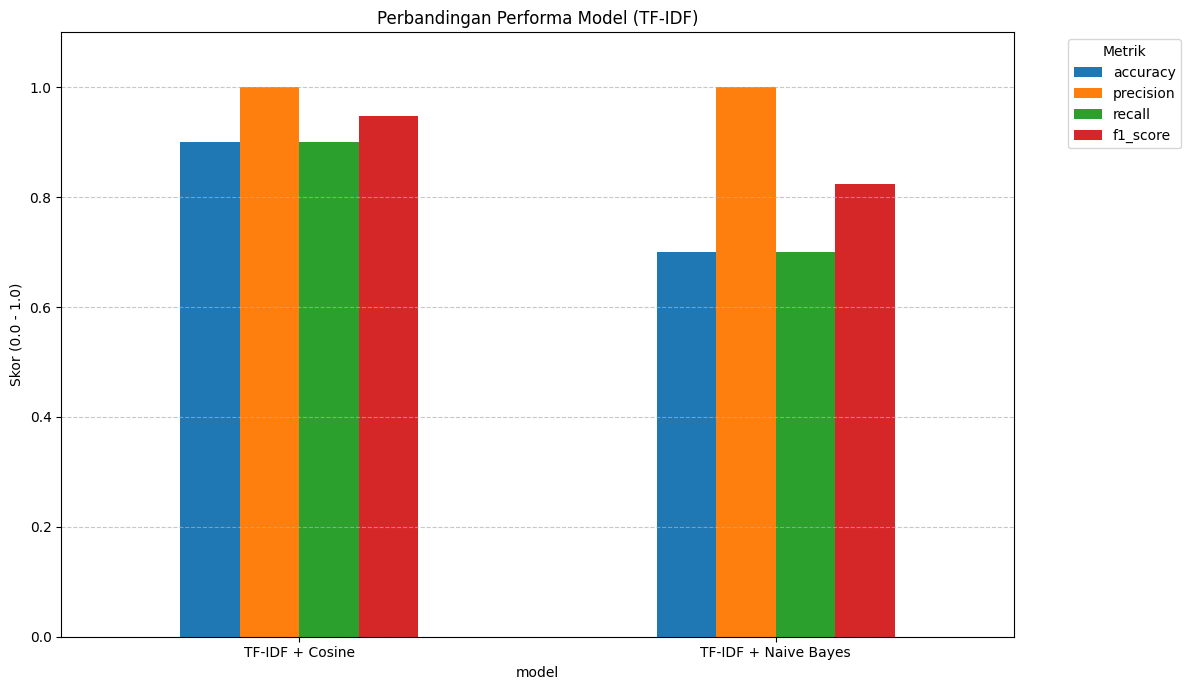


🎉 EVALUASI LENGKAP SELESAI 🎉


In [7]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from typing import Dict, List

# ==============================================================================
# TAHAP 5: EVALUASI PERFORMA MODEL
# ==============================================================================
print("--- TAHAP 5: EVALUASI PERFORMA MODEL (Naive Bayes vs. Cosine Similarity) ---")

# === 1. Konfigurasi Path dan Memuat Data Uji ===
print("\n[1/4] Memuat file hasil prediksi dan ground truth...")

# Path ke file input untuk tahap ini
EVAL_DIR = "data/eval"
RESULTS_DIR = "data/results"

# --- PERUBAHAN: Path disesuaikan untuk hasil NB dan Cosine ---
NB_PRED_PATH = os.path.join(RESULTS_DIR, 'predictions_nb.csv')
COSINE_PRED_PATH = os.path.join(RESULTS_DIR, 'predictions_cosine.csv')
QUERY_PATH = os.path.join(EVAL_DIR, "queries.json")

# Path untuk output dari tahap ini
METRICS_CSV_PATH = os.path.join(RESULTS_DIR, 'evaluation_metrics_nb_vs_cosine.csv')
VIZ_PATH = os.path.join(RESULTS_DIR, 'performance_comparison_nb_vs_cosine.png')
FAILED_NB_PATH = os.path.join(RESULTS_DIR, 'failed_cases_nb.json')
FAILED_COSINE_PATH = os.path.join(RESULTS_DIR, 'failed_cases_cosine.json')

# Memuat ground truth dari queries.json
with open(QUERY_PATH, 'r', encoding='utf-8') as f:
    test_queries = json.load(f)
ground_truth_dict = {str(q.get('query_id')): str(q.get('ground_truth_case_id')) for q in test_queries}

# Memuat hasil prediksi
df_nb = pd.read_csv(NB_PRED_PATH)
df_cosine = pd.read_csv(COSINE_PRED_PATH)

print("✅ Semua file yang dibutuhkan berhasil dimuat.")


# === 2. Definisi Fungsi-fungsi Evaluasi ===
print("\n[2/4] Mendefinisikan fungsi-fungsi evaluasi...")

# Fungsi ini untuk mengevaluasi model Top-K seperti TF-IDF + Cosine
def evaluate_retrieval(predictions_df: pd.DataFrame, ground_truth: Dict, model_name: str, k: int = 5) -> Dict:
    y_true, y_pred = [], []
    for _, row in predictions_df.iterrows():
        query_id = str(row['query_id'])
        gt_id = ground_truth.get(query_id)
        # Mengambil dari kolom top_5_case_ids
        retrieved_ids = [s.strip() for s in str(row.get('top_5_case_ids', '')).split(',')]
        hit = 1 if gt_id in retrieved_ids[:k] else 0
        y_true.append(1)
        y_pred.append(hit)
    
    return {"model": model_name, "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1_score": f1_score(y_true, y_pred, zero_division=0)}

# Fungsi ini untuk mengevaluasi model Top-1 seperti Naive Bayes
def evaluate_prediction(predictions_df: pd.DataFrame, ground_truth: Dict, model_name: str) -> Dict:
    y_true, y_pred = [], []
    for _, row in predictions_df.iterrows():
        query_id = str(row['query_id'])
        gt_id = ground_truth.get(query_id)
        # Mengambil dari kolom top_1_case_id
        predicted_id = str(row.get('top_1_case_id', ''))
        hit = 1 if gt_id == predicted_id else 0
        y_true.append(1)
        y_pred.append(hit)

    return {"model": model_name, "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1_score": f1_score(y_true, y_pred, zero_division=0)}

def save_failed_cases(predictions_df: pd.DataFrame, ground_truth: Dict, output_file: str, model_type: str):
    failed_cases, original_queries = [], {str(q.get('query_id')): q.get('query_text') for q in test_queries}
    for _, row in predictions_df.iterrows():
        query_id, gt_id, hit = str(row['query_id']), ground_truth.get(str(row['query_id'])), False
        if model_type == 'retrieval':
            predicted_output = [s.strip() for s in str(row.get('top_5_case_ids', '')).split(',')]
            if gt_id in predicted_output: hit = True
        else: # classification
            predicted_output = [str(row.get('top_1_case_id', ''))]
            if gt_id == predicted_output[0]: hit = True
        if not hit:
            failed_cases.append({"query_id": query_id, "query_text": original_queries.get(query_id), "ground_truth": gt_id, "predicted": predicted_output})
    with open(output_file, "w", encoding="utf-8") as f: json.dump(failed_cases, f, indent=2, ensure_ascii=False)
    print(f"   -> {len(failed_cases)} kasus gagal untuk '{model_type}' disimpan di: {output_file}")

print("✅ Semua fungsi evaluasi siap.")

# === 3. Eksekusi Evaluasi & Penyimpanan Hasil ===
print("\n[3/4] Mengeksekusi evaluasi dan menyimpan laporan...")

# Jalankan evaluasi untuk TF-IDF + Cosine Similarity (Retrieval)
cosine_metrics = evaluate_retrieval(df_cosine, ground_truth_dict, "TF-IDF + Cosine")

# Jalankan evaluasi untuk Naive Bayes (Klasifikasi)
nb_metrics = evaluate_prediction(df_nb, ground_truth_dict, "TF-IDF + Naive Bayes")

# Gabungkan metrik dan simpan ke CSV
df_metrics = pd.DataFrame([cosine_metrics, nb_metrics])
df_metrics.to_csv(METRICS_CSV_PATH, index=False)
print(f"   -> Laporan metrik gabungan disimpan di: {METRICS_CSV_PATH}")

# Simpan kasus kegagalan
save_failed_cases(df_cosine, ground_truth_dict, FAILED_COSINE_PATH, model_type='retrieval')
save_failed_cases(df_nb, ground_truth_dict, FAILED_NB_PATH, model_type='classification')

print("\n--- Laporan Performa Model ---")
display(df_metrics)

# === 4. Visualisasi Performa ===
print("\n[4/4] Membuat visualisasi perbandingan...")

df_plot = df_metrics.set_index('model')
df_plot.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Perbandingan Performa Model (TF-IDF)')
plt.ylabel('Skor (0.0 - 1.0)')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrik', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig(VIZ_PATH, bbox_inches='tight')
print(f"✅ Visualisasi disimpan di: {VIZ_PATH}")
plt.show()

print("\n🎉 EVALUASI LENGKAP SELESAI 🎉")